# 8.2 목표를 정해 공격하기



In [1]:
import torch
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms

import numpy as np
from PIL import Image
import json

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

torch.manual_seed(1)

In [3]:
CLASSES = json.load(open('./imagenet_samples/imagenet_classes.json'))
idx2class = [CLASSES[str(i)] for i in range(1000)]
class2idx = {v:i for i,v in enumerate(idx2class)}

In [4]:
vgg16 = models.vgg16(pretrained=True)
vgg16.eval()
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [5]:
softmax = torch.nn.Softmax()

In [6]:
img_transforms = transforms.Compose([transforms.Scale((224, 224), Image.BICUBIC),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
def norm(x):
    return 2.*(x/255.-0.5)

def unnorm(x):
    un_x = 255*(x*0.5+0.5)
    un_x[un_x > 255] = 255
    un_x[un_x < 0] = 0
    un_x = un_x.astype(np.uint8)
    return un_x

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:207: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


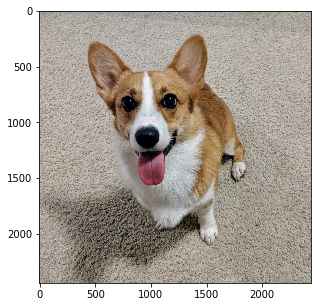

In [7]:
img = Image.open('imagenet_samples/corgie.jpg')
img_tensor = img_transforms(img)

plt.figure(figsize=(10,5))
plt.imshow(np.asarray(img))

In [8]:
img_tensor.requires_grad_(True)
out = vgg16(img_tensor.unsqueeze(0))
probs = softmax(out)
cls_idx = np.argmax(out.data.numpy())
print(str(cls_idx) + ":" + idx2class[cls_idx] + ":" + str(out.data.numpy()[0][cls_idx]) + ":" + str(probs.data.numpy()[0][cls_idx]))

263:Pembroke, Pembroke Welsh corgi:22.998934:0.8829355


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
learning_rate = 1
img = Image.open('imagenet_samples/corgie.jpg')
fake_img_tensor = img_transforms(img)
img_var_fake = torch.autograd.Variable(fake_img_tensor.unsqueeze(0), requires_grad=True)
fake_class_idx = class2idx['street sign']
for i in range(100):
    out_fake = vgg16(img_var_fake)
    _, out_idx = out_fake.data.max(dim=1)
    if out_idx.numpy() == fake_class_idx:
        print('Fake generated in ' + str(i) + ' iterations')
        break
    out_fake[0,fake_class_idx].backward()
    img_var_fake_grad = img_var_fake.grad.data
    img_var_fake.data += learning_rate*img_var_fake_grad/img_var_fake_grad.norm()
    img_var_fake.grad.data.zero_()
probs_fake = softmax(out_fake)
print(str(fake_class_idx) + ":" + idx2class[fake_class_idx] + ":" + str(out_fake.data.numpy()[0][fake_class_idx]) + ":" + str(probs_fake.data.numpy()[0][fake_class_idx]))

Fake generated in 17 iterations
919:street sign:26.3378:0.58350843


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


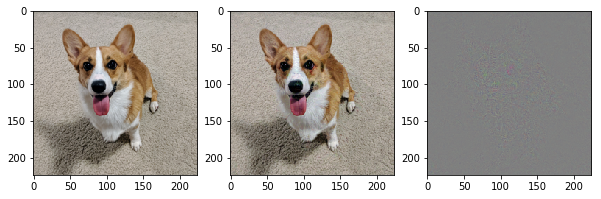

In [10]:
plt.figure(figsize=(10,5))
plt.subplot(1,3,1)
plt.imshow(unnorm(img_tensor.detach().numpy()).transpose(1,2,0))
plt.subplot(1,3,2)
plt.imshow(unnorm(img_var_fake.data.detach().numpy()[0]).transpose(1,2,0))
plt.subplot(1,3,3)
plt.imshow(unnorm(img_var_fake.data.detach().numpy()[0] - img_tensor.detach().numpy()).transpose(1,2,0))